# Solvation
VeloxChem has two ways to compute the Gibbs energy of solvation - implicit CPCM and explicit solvation using alchemical free energy perturbation.

In [1]:
import veloxchem as vlx

In this example we will solvate a phenolate anion using both methods. First we define the molecule object and set the charge to -1.

In [10]:
molecule = vlx.Molecule.read_smiles('c1ccccc1[O-]')
molecule.set_charge(-1)
molecule.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Implicit solvation
To compute the solvation free energy using CPCM we simply compute the gas phase energy first, then use ```.solvation_model = 'cpcm'``` on the scf driver, and then compute the scf again. The free energy of solvation will be the difference between the cpcm_results and scf_results.

In [3]:
basis = vlx.MolecularBasis.read(molecule, 'def2-svp')
scf_drv = vlx.ScfRestrictedDriver()
scf_drv.xcfun = "b3lyp"
scf_results = scf_drv.compute(molecule, basis)
scf_drv.solvation_model = 'cpcm'
cpcm_results = scf_drv.compute(molecule, basis)

                                                                                                                          
                                            Self Consistent Field Driver Setup                                            
                                                                                                                          
                   Wave Function Model             : Spin-Restricted Kohn-Sham                                            
                   Initial Guess Model             : Superposition of Atomic Densities                                    
                   Convergence Accelerator         : Two Level Direct Inversion of Iterative Subspace                     
                   Max. Number of Iterations       : 50                                                                   
                   Max. Number of Error Vectors    : 10                                                                   
                

In [4]:
Gsolv = cpcm_results['scf_energy'] - scf_results['scf_energy']

print('Experimental solvation free energy:')
print('-72.5 kcal/ mol')
print(f"{-72.5*4.184:.1f} kJ/ mol")
print(" ")
print('CPCM solvation free energy:')
print(f"{Gsolv*627.5:.1f} kcal/mol")
print(f"{Gsolv*2625.5:.1f} kJ/mol")

Experimental solvation free energy:
-72.5 kcal/ mol
-303.3 kJ/ mol
 
CPCM solvation free energy:
-61.6 kcal/mol
-257.6 kJ/mol


### Explicit Solvation
To compute the solvation using alchemical free energy perturbation protocol you need the two lines below. This will generate a force field with RESP charges (HF/6-31G*), solvate it in a box with 2 nm padding and run every lamda for 1 ns.

To run the cells below remove the """ in the cells. These computations can be a bit slow so do not run them if you do not have a good GPU.

In [5]:
"""
explicit_solvation = vlx.SolvationFepDriver()
explicit_solvation_result = explicit_solvation.compute_solvation(molecule, solvent='spce')
"""

"\nexplicit_solvation = vlx.SolvationFepDriver()\nexplicit_solvation_result = explicit_solvation.compute_solvation(molecule, solvent='spce')\n"

If you want to try it a bit faster you can lower the padding and simulation time per lambda. If you have a GPU it will be significantly faster if you specify a different platform than CPU (OpenCL, HIP, CUDA).

In [6]:
%%time
explicit_solvation = vlx.SolvationFepDriver()
explicit_solvation.padding = 1.1
explicit_solvation.platform = "OpenCL"
explicit_solvation.num_steps = 100000
explicit_solvation_result = explicit_solvation.compute_solvation(molecule, solvent='spce')

                                                 VeloxChem System Builder                                                 
                                                                                                                          
* Info * Solvating the solute with spce molecules                                                                         
* Info * Padding: 1.1 nm                                                                                                  
                                                                                                                          
* Info * The volume of the solute is: 0.10 nm^3                                                                           
* Info * The box size is: 2.70 x 2.70 x 2.70 nm^3                                                                         
* Info * The volume available for the solvent is: 19.48 nm^3                                                              
* Info * The exp


******* JAX 64-bit mode is now on! *******
*     JAX is now set to 64-bit mode!     *
*   This MAY cause problems with other   *
*      uses of JAX in the same code.     *
******************************************



Free energy for stage 1: -106.2308 +/- 0.6140 kcal/mol
* Info * Starting removing GSC potential (Stage 2)...
                                                                    
* Info * Running lambda = 1.0, stage = 2...                                                                               
* Info * System XML written to solvated_system_1.0_stage2.xml                                                             
* Info * Lambda 1.0 simulation time: 0.10 ns. Elapsed time: 52.18 s                                                       
* Info * Performance: 6.90 ns/hour                                                                                        
* Info * Lambda = 1.0 completed. Performance: 6.90 ns/hour                                                                
* Info * Running lambda = 0.8, stage = 2...                                                                               
* Info * System XML written to solvated_system_0.8_stage2.xml                       

In [7]:
solvation = explicit_solvation_result[-1]-molecule.get_charge()*57.7/4.184 #correction term added for the potential in taking the ion across the interface https://doi.org/10.1021/acs.jpclett.7b01125
print(f"{solvation:.1f} kcal/mol")
print(f"{solvation*4.184:.1f} kJ/mol")

-75.2 kcal/mol
-314.8 kJ/mol


You can also specify your own force field for both the solute and solven. Here I have used a forcefield with RESP charges computed with DFT and CPCM.

In [8]:
%%time
ff_gen = vlx.ForceFieldGenerator()
ff_gen.create_topology(molecule, basis, cpcm_results)
explicit_solvation2 = vlx.SolvationFepDriver()
explicit_solvation2.padding = 1.1
explicit_solvation2.platform = "OpenCL"
explicit_solvation2.num_steps = 100000
explicit_solvation_result2 = explicit_solvation2.compute_solvation(molecule, ff_gen_solute=ff_gen, solvent='spce')

* Info * Using provided SCF result for RESP charges                                                                       
***********                                                                                                               
* Warning * Recommended basis set 6-31G* is not used!                                                                     
***********                                                                                                               
                                                                                                                          
                                                                                                                          
                                                RESP Charges Driver Setup                                                 
                                                                                                                          
                

In [9]:
solvation2 = explicit_solvation_result2[-1]-molecule.get_charge()*57.7/4.184
print(solvation2)
print(solvation2*4.184)

-77.79720155322435
-325.50349129869073


### How large systems do we use solvation free energy for?

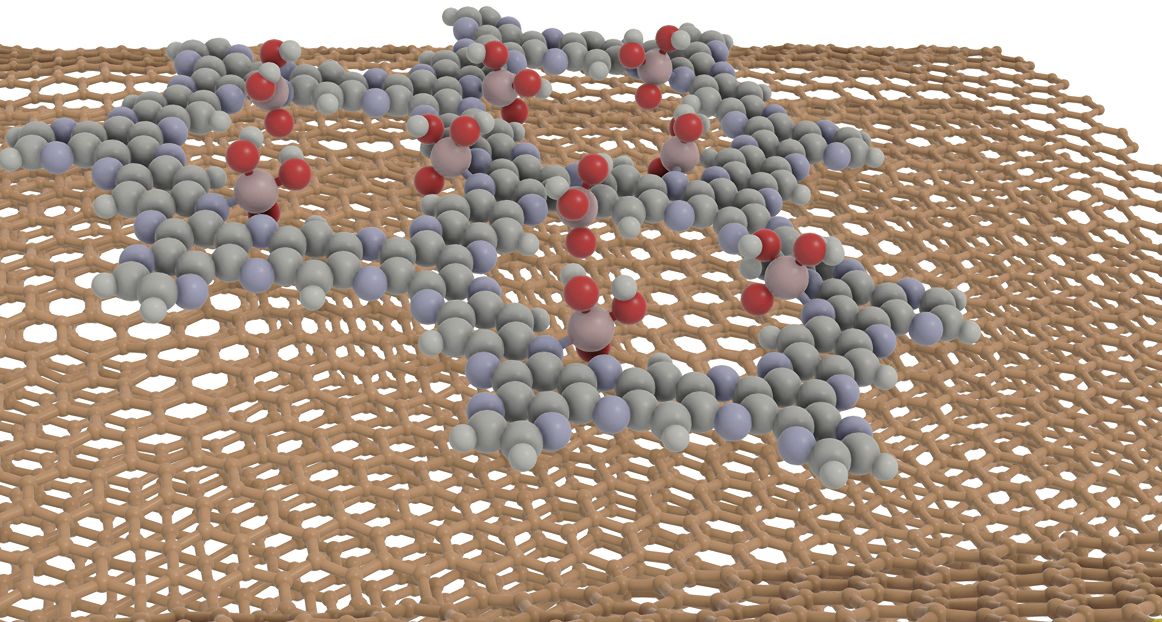